Obtain data form Coinranking API   

In [1]:
import requests,json
import pandas as pd

coin_id = 15 # 1 is BTC, 2 is ETH, 15 is Neo
time_range = "1y"
price_currency = "EUR"
response = requests.get("https://api.coinranking.com/v1/public/coin/%s/history/%s?base=%s" % (coin_id, time_range, price_currency))
response

<Response [200]>

Dump response to JSON file

In [2]:
import os

os.makedirs('responses', exist_ok=True)
file = open('responses/coin%d-history%s-currency%s.json' % (coin_id, time_range, price_currency),'w+')
file.write(response.text)
file.close()


Load response in pandas data frame

In [3]:
response_json = json.loads(response.text)['data']['history']
data_frame = pd.DataFrame(response_json)
data_frame['price'] = pd.to_numeric(data_frame['price'])
data_frame['timestamp'] = pd.to_datetime(data_frame['timestamp'], unit='ms').dt.date
data_sequence = data_frame.groupby('timestamp').mean()['price']
data_sequence

timestamp
2018-09-09    16.842200
2018-09-10    16.019213
2018-09-11    16.017558
2018-09-12    15.656370
2018-09-13    14.719648
                ...    
2019-09-04     8.314067
2019-09-05     8.101336
2019-09-06     8.210745
2019-09-07     8.118801
2019-09-08     8.373332
Name: price, Length: 365, dtype: float64

Normalize data

In [4]:
chunk_size = 30
chunks = []
for i in range(len(data_sequence) - chunk_size+1):
    chunks.append(data_sequence[i:i+chunk_size])

price_change_sequence = []
for chunk in chunks:
    price_change_sequence.append([(price / chunk[0]) - 1 for price in chunk])
len(price_change_sequence)

336

Split data into training and test sets

In [5]:
import numpy as np

price_matrix = np.array(price_change_sequence)
train_set_size = int(len(price_matrix) * 0.8)
train_set = price_matrix[:train_set_size, :]
np.random.shuffle(train_set)

x_train_set, y_train_set = train_set[:train_set_size, :-1], train_set[:train_set_size, -1]
x_test_set, y_test_set = price_matrix[train_set_size:, :-1], price_matrix[train_set_size:, -1]

x_train_set = np.reshape(x_train_set, (x_train_set.shape[0], x_train_set.shape[1], 1))
x_test_set = np.reshape(x_test_set, (x_test_set.shape[0], x_test_set.shape[1], 1))

len(x_train_set), len(x_test_set)

(268, 68)

Build LSTM network

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation


lstm = Sequential()
lstm.add(LSTM(units=chunk_size, return_sequences=True, input_shape=(None, 1)))
lstm.add(Dense(units=32,activation='linear'))
lstm.add(LSTM(units=chunk_size, return_sequences=False))
lstm.add(Dense(units=1,activation='linear'))
lstm.compile(optimizer='rmsprop',loss='mean_squared_error',  metrics=['mse', 'mae', 'mape', 'cosine'],)

Using TensorFlow backend.


Train network

In [7]:
import time
start_time = time.time()
history = lstm.fit(x=x_train_set,
          y=y_train_set,
          batch_size=2,
          epochs=20,
          validation_split=0.05)
end_time = time.time()
processing_time = end_time - start_time
processing_time

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 254 samples, validate on 14 samples
Epoch 1/20
254/254 [==============================] - 7s 27ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0885 - mean_absolute_percentage_error: 165.7905 - cosine_proximity: -0.7480 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0330 - val_mean_absolute_percentage_error: 234.7566 - val_cosine_proximity: -0.5714
Epoch 2/20
254/254 [==============================] - 5s 20ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 101.8579 - cosine_proximity: -0.8110 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0293 - val_mean_absolute_percentage_error: 404.1116 - val_cosine_proximity: -0.5714
Epoch 3/20
254/254 [==============================] - 5s 19ms/step - loss: 0.0063 - mean_squared_error: 0

254/254 [==============================] - 5s 20ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 86.2114 - cosine_proximity: -0.9134 - val_loss: 8.1979e-04 - val_mean_squared_error: 8.1979e-04 - val_mean_absolute_error: 0.0206 - val_mean_absolute_percentage_error: 130.3637 - val_cosine_proximity: -0.5714


107.80656790733337

Save network model

In [8]:
os.makedirs('model', exist_ok=True)
lstm.save('model/coin%d-history%s-currency%s.h5' % (coin_id, time_range, price_currency))

Load trained model from file

In [9]:
# lstm.load('model/coin%d-history%s-currency%s.h5' % (coin_id, time_range, price_currency))

Predict

In [10]:
predictions = lstm.predict(x_test_set, batch_size=2)

Denormalize predictions 

In [11]:
price_matrix = np.array(chunks)
denormalized_x_test = price_matrix[train_set_size:,:-1]
denormalized_y_test = price_matrix[train_set_size:,-1]
denormalized_predictions = []
predictions = np.reshape(predictions, (predictions.shape[0]))
for index in range(len(predictions)):
    pred = (predictions[index]+1)* denormalized_x_test[index][0]
    denormalized_predictions.append(pred)
denormalized_predictions = np.array(denormalized_predictions)

Visualize results

In [12]:
import matplotlib.pyplot as plt

print(len(range(69)), len(denormalized_y_test), len(denormalized_predictions))

plot_data_frame = pd.DataFrame({'date': range(68) ,'actual_values': denormalized_y_test, 'predictions': denormalized_predictions}) 
ax = plt.gca()

plot_data_frame.plot(kind='line',x='date',y='actual_values',ax=ax)
plot_data_frame.plot(kind='line',x='date',y='predictions', color='red', ax=ax)

plt.show()

69 68 68


<Figure size 640x480 with 1 Axes>

Visualize mean squared error

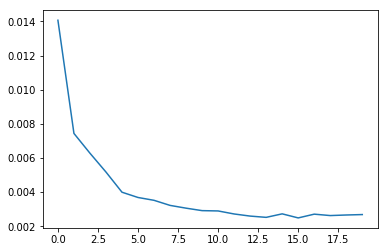

In [14]:
plt.plot(history.history['mean_squared_error'])
plt.show()